In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [59]:
def BoB_plot(input_data,lat,lon,t,title,output):
########## Data ########
    input_data=input_data.rename({input_data.dims[t]:'time'})
    datasets={}
    for i in range(1994,2019):
        summer_unfiltered=input_data.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
        datasets[i]=[]
        datasets[i].append(summer_unfiltered)
    lon=input_data[input_data.dims[lon]].data
    lat=input_data[input_data.dims[lat]].data
########## Info ######
    Summer_enso_info={}
    Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                        1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                        2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                        2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                        2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                        2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

    Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
    Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]
##########  Plotting ###########
    fig, axs = plt.subplots(nrows=5,ncols=5,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    y_label=set([0,5,10,15,20])
    x_label=set([20,21,22,23,24])
    L2=[-20,-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15,20]
    for i,year in enumerate(datasets):
            data=datasets[year]
            cs=axs[i].contourf(lon,lat,data[0],
                              levels=L2,transform = ccrs.PlateCarree(),
                              cmap='seismic',extend='both')
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 15, weight='bold')
            axs[i].coastlines()
            if i in y_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
            if year in Elnino_years:
                axs[i].text(88,23.5, Summer_enso_info[year],color='red', fontsize = 9,weight='bold')
            if year in Lanina_years:
                axs[i].text(88,23.5, Summer_enso_info[year],color='blue', fontsize = 9,weight='bold')

    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=120)
    
    return 

# Altimeter Unfiltered

In [15]:
BoB_altimeter=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021.nc',autoclose=True).sel(latitude=slice(4,25),longitude=slice(78,100)).sla

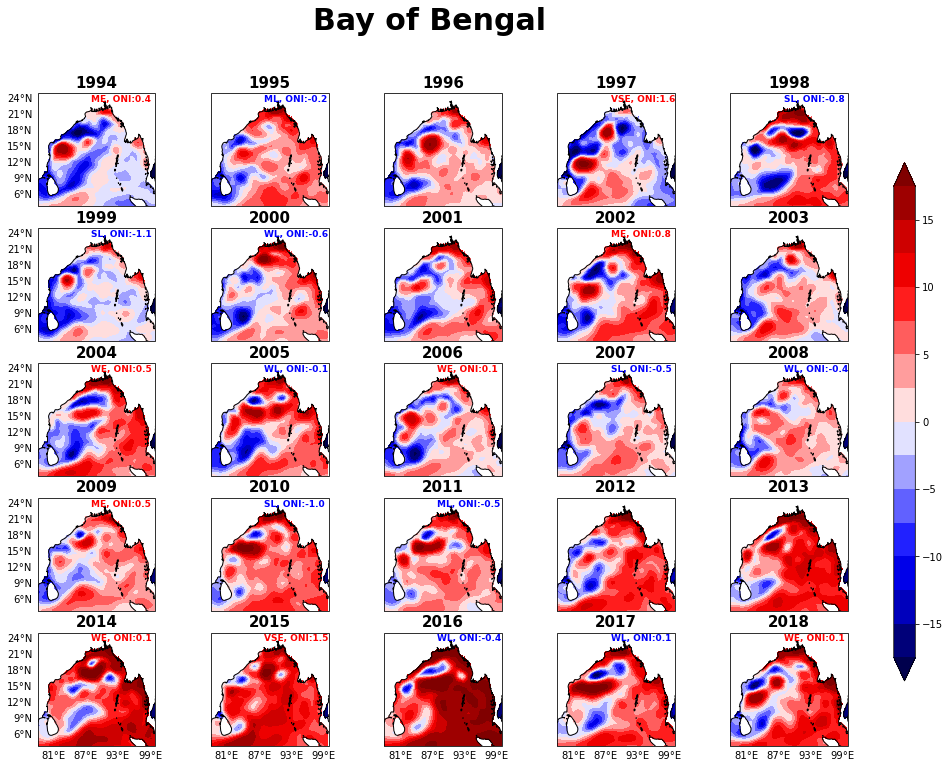

In [45]:
i=BoB_altimeter
#print(i.dims)
BoB_plot(i,"Bay of Bengal",'BoB.jpg')

# LCS Unfilltered

In [139]:
BoB_lcs=xr.open_mfdataset('lcs_sla1.nc',autoclose=True).sel(lat=slice(4,25),lon=slice(78,100)).sla

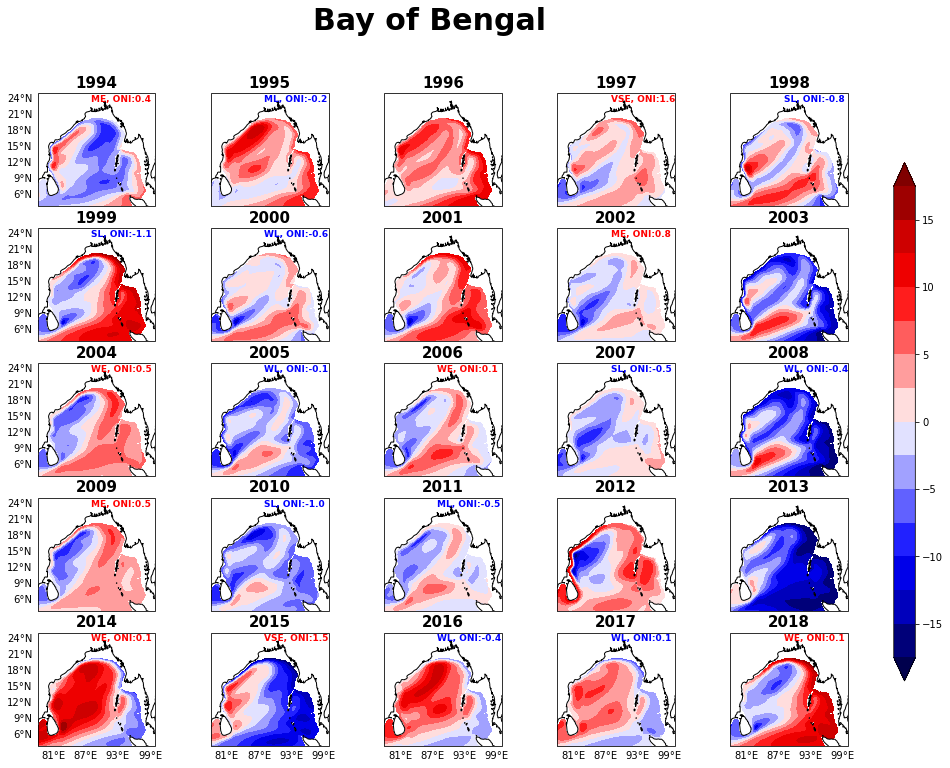

In [18]:
i=BoB_lcs
#print(i.dims)
BoB_plot(i,"Bay of Bengal",'BoB.jpg')

## Filtering code ------------------

In [19]:
import scipy.signal as signal
def butterworth_lowpass_filter(data, cutoff_time, axis=0):
    cutoff_freq=1/cutoff_time
    nyfreq=cutoff_freq*2
    order=4
    B, A = signal.butter(order, nyfreq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

# Altimeter Filtered

## ferret filtering

In [138]:
BoB_ferret_filtered=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021_low_new.nc',autoclose=True).sel(LATITUDE=slice(4,25),LONGITUDE=slice(78,100)).SLA_LOW

In [21]:
BoB_ferret_filtered

<xarray.DataArray 'SLA_LOW' (TIME: 9672, LATITUDE: 84, LONGITUDE: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * LATITUDE   (LATITUDE) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88
  * TIME       (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
Attributes:
    long_name:  LSL_LOWPASS(SLA,400,400)
    history:    From IO_sla_new

('TIME', 'LATITUDE', 'LONGITUDE')


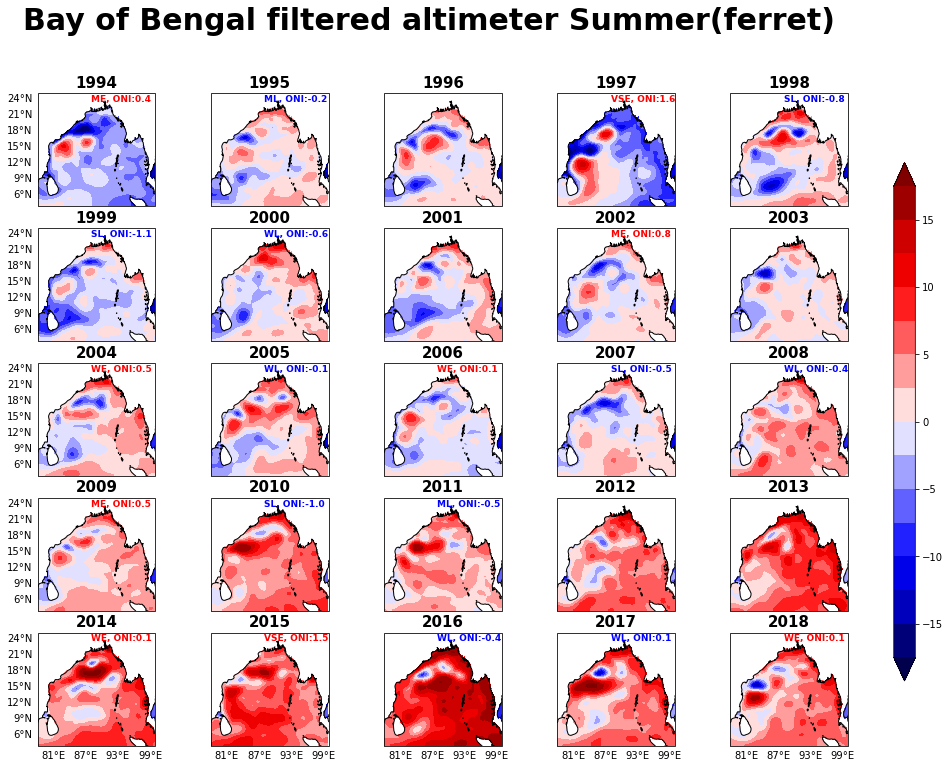

In [22]:
i=BoB_ferret_filtered
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered altimeter Summer(ferret)",
         'BoB_filtered_altimeter_ferret.jpg')

## Altimeter filtering in python

In [23]:
BoB_altimeter_low = butterworth_lowpass_filter(BoB_altimeter, 400)


In [24]:
BoB_altimeter_low=xr.DataArray(BoB_altimeter_low,coords=
                                   {"time": BoB_altimeter.time, "latitude": BoB_altimeter.latitude,
                          "longitude": BoB_altimeter.longitude},
                  dims=["time", "latitude","longitude"])
BoB_altimeter_low['sla_low']=BoB_altimeter_low


('time', 'latitude', 'longitude')


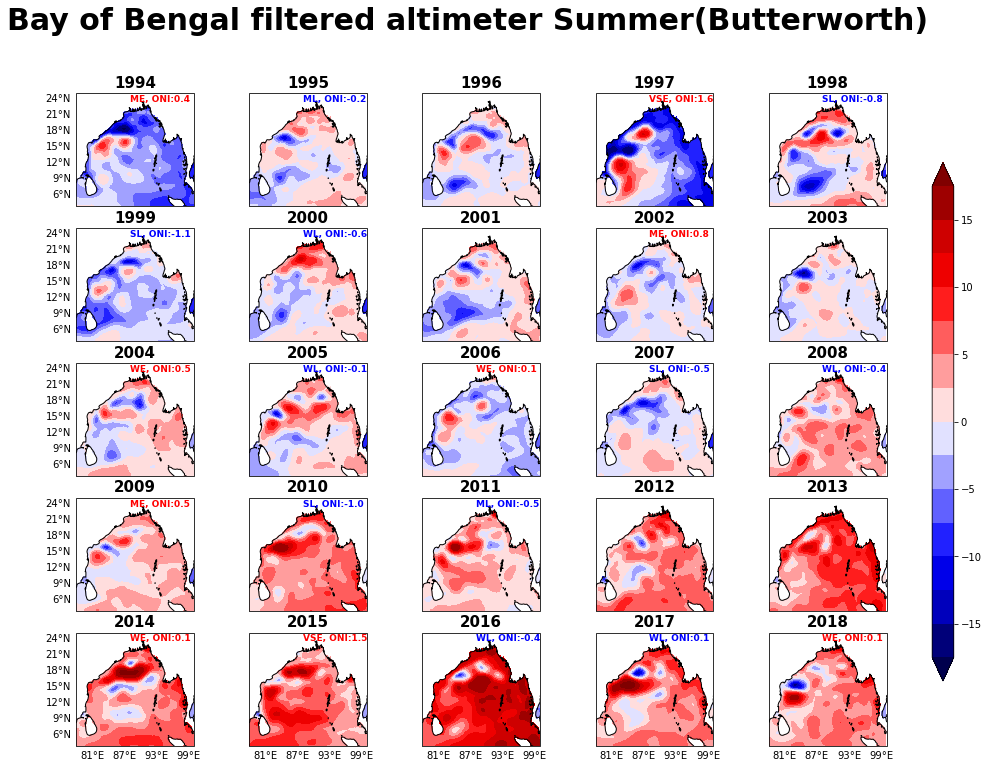

In [25]:
i=BoB_altimeter_low
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered altimeter Summer(Butterworth)",
         'BoB_filtered_altimeter.jpg')

# LCS Filtered

In [7]:
BoB_lcs_low = butterworth_lowpass_filter(BoB_lcs, 400)


In [9]:

BoB_lcs_low=xr.DataArray(BoB_lcs_low,coords={"time": BoB_lcs.time, "lat": BoB_lcs.lat,
                          "lon": BoB_lcs.lon},
                  dims=["time", "lat","lon"])

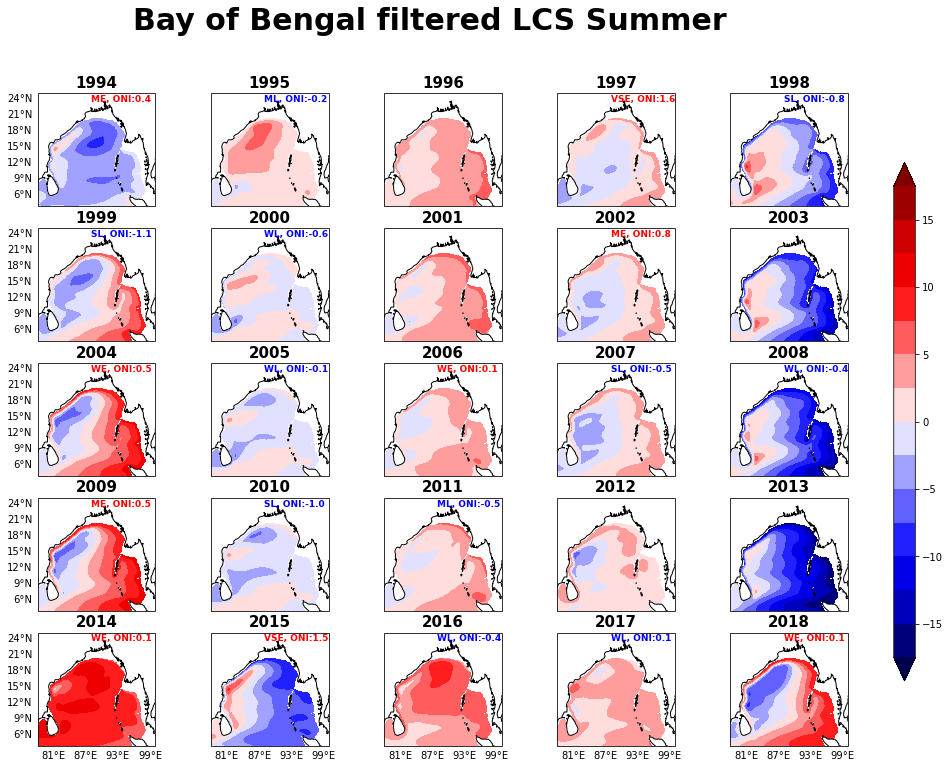

In [26]:
i=BoB_lcs_low
#print(i.dims)
BoB_plot(i,"Bay of Bengal filtered LCS Summer NEW",
         'BoB_filtered_lcs_new.jpg')

In [89]:
BoB_lcs_low_old=xr.open_mfdataset('/home/NCAOR/supriyog/.backup_files/BoB_SLA_work/BoB_plots/400dayslow_LCSCR.nc').SLA_LOW.squeeze()

('TIME', 'LAT329_549', 'LON479_699')


/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


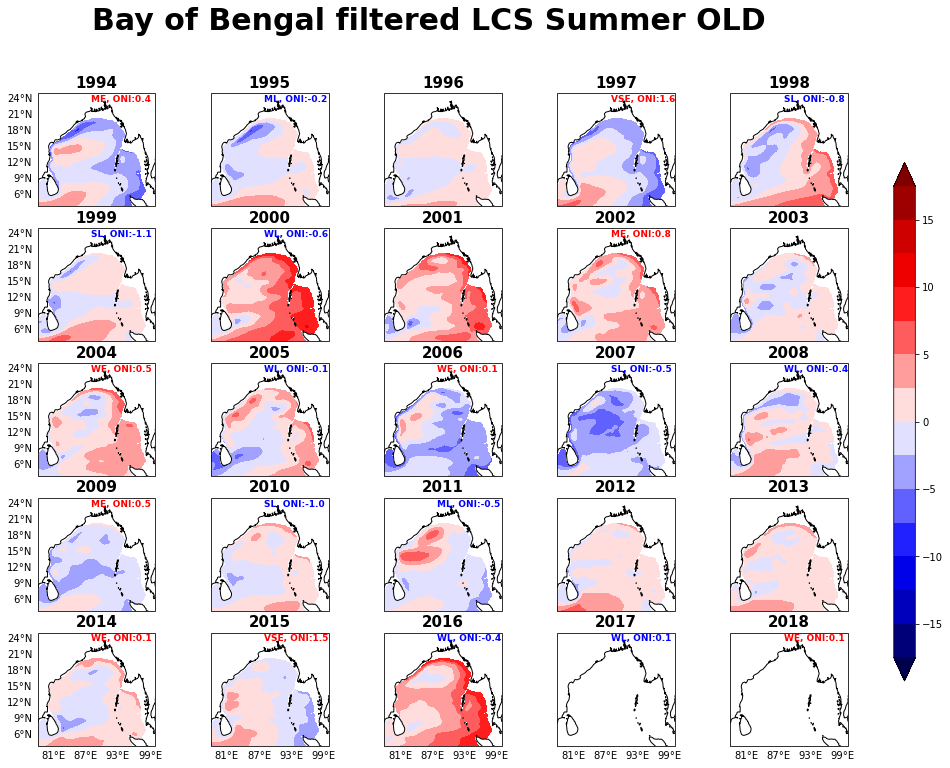

In [90]:
i=BoB_lcs_low_old
print(i.dims)
BoB_plot(i,1,2,0,"Bay of Bengal filtered LCS Summer OLD",
         'BoB_filtered_lcs_old.jpg')


# Correlation

In [269]:
d1=BoB_altimeter.sel(time=slice('2000-01-01','2000-01-10'))
d2=BoB_altimeter_low.sel(time=slice('2000-01-01','2000-01-10')).mean(dim='time')
print(d1.dims)
print(d2.dims)


('time', 'latitude', 'longitude')
('latitude', 'longitude')


In [261]:
d2.shape

(84, 88)

In [262]:
d1.shape

(10, 84, 88)

In [263]:
d3=xr.corr(d1,d2_new,dim='time')


/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in 

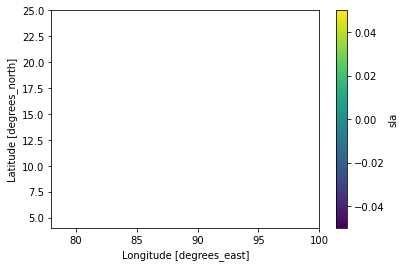

In [265]:
d3.plot()

In [202]:
d2_new=d2.interp(lat=d1.latitude, lon=d1.longitude)

In [205]:
d2_new=d2_new.drop('lat')
d2_new=d2_new.drop('lon')


/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


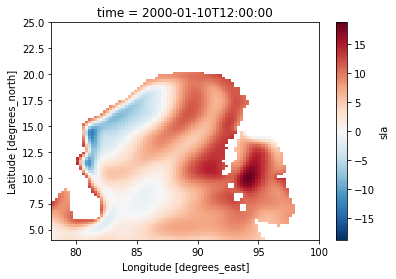

In [210]:
d2_new[9].plot()

In [170]:
d3=xr.corr(d1,d2_new,dim='time')


In [197]:
d3.to_netcdf('corr.nc')

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in 

In [184]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

# Point checking 

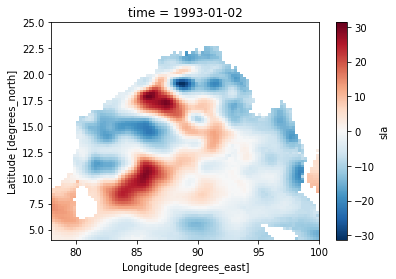

In [211]:
BoB_altimeter[1].plot()

In [229]:
x1,y1=15,84
x2,y2=17.5,86

In [ ]:
p1=BoB_altimeter.sel(latitude=slice(10,11),longitude=slice(83,84)).mean(dim=latitude).mean(dim=longitude)

In [ ]:
p1